In [2]:
from funs import *
import os
import numpy as np
import pandas as pd
from PySpice.Spice.Xyce.Server import XyceServer
from lmfit import minimize, Parameters
import lmfit
import time
import pandas as pd
import csv
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

In [3]:
C_eq = 6.2230e-16
time, output = run_tran_inv(C_eq)

time = np.array(time)
output = np.array(output)
output = 0.7 - output


df = pd.read_csv('netlist_1.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 5]]
df = df.apply(pd.to_numeric, errors='coerce')  
df.dropna(inplace=True) 
target_data = df.values


C:\Users\y50046737\AppData\Local\Temp\ipykernel_32680\1681964502.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist_1.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 5]]


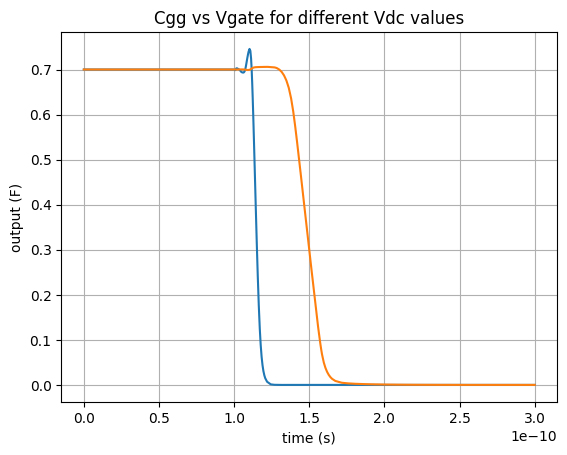

[0.00000000e+00 5.00000000e-13 1.50000000e-12 3.50000000e-12
 7.50000000e-12 1.55000000e-11 2.55000000e-11 3.55000000e-11
 4.55000000e-11 5.55000000e-11 6.55000000e-11 7.55000000e-11
 8.55000000e-11 9.55000000e-11 1.00000000e-10 1.00006250e-10
 1.00018750e-10 1.00031250e-10 1.00056250e-10 1.00081250e-10
 1.00131250e-10 1.00181250e-10 1.00231250e-10 1.00331250e-10
 1.00531250e-10 1.00731250e-10 1.00765679e-10 1.00800107e-10
 1.00868965e-10 1.00937822e-10 1.01000000e-10 1.01006886e-10
 1.01013083e-10 1.01019280e-10 1.01031674e-10 1.01056463e-10
 1.01081252e-10 1.01130829e-10 1.01180406e-10 1.01279561e-10
 1.01378715e-10 1.01477870e-10 1.01676179e-10 1.02072797e-10
 1.02469415e-10 1.02866034e-10 1.03262652e-10 1.03619608e-10
 1.03919640e-10 1.04181793e-10 1.04417731e-10 1.04653669e-10
 1.04889606e-10 1.05125544e-10 1.05361482e-10 1.05597420e-10
 1.06069295e-10 1.06541170e-10 1.07013046e-10 1.07424253e-10
 1.07770247e-10 1.08080418e-10 1.08390588e-10 1.08700759e-10
 1.09010929e-10 1.093211

In [4]:
plt.plot(time, output, linestyle='-')
plt.plot(target_data[:,0], target_data[:,1], linestyle='-')
plt.xlabel('time (s)')
plt.ylabel('output (F)')
plt.title('Cgg vs Vgate for different Vdc values')
plt.grid(True)
plt.show()
print(time)
print(output)

In [26]:
def calculate_error(sim_data, target_data):
    return np.mean((np.array(sim_data) - np.array(target_data))**2)

def get_points(data):

    vdd = 0.7
    v20 = 0.2 * vdd
    v80 = 0.8 * vdd
    v10 = 0.1 * vdd
    v90 = 0.9 * vdd
    data = list(zip(*data))
    time = np.array(data[0])
    Vout = np.array(data[1])

    f_interp = interp1d(Vout, time, kind='linear', fill_value='extrapolate')


    t20 = f_interp(v20)
    t80 = f_interp(v80)
    t10 = f_interp(v10)
    t90 = f_interp(v90)
    delay1 =t20-t80
    delay2 =t10-t90

    
    return [delay1,delay2]


def objective_function(params):
    total_error = 0.0
    C_eq = params['C_eq'].value
    print("Current parameters:", params)
    # Run simulations
    time, output = run_tran(C_eq)
    data = np.column_stack((time, output))


    df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]
    df = df.apply(pd.to_numeric, errors='coerce')  
    df.dropna(inplace=True) 

    target_data = df.values

    points = get_points(data)
    target_points = get_points(target_data)
    points=np.array(points)
    target_points = np.array(target_points)
    

    total_error += calculate_error(points*1e10, target_points*1e10) #0.1ns
    
    print("Current error:", total_error)
    return total_error

In [ ]:
time, output_ = run_tran_inv(1.0000e-15)
time = np.array(time)
output_ = np.array(output_)
output_ = 0.7-output_
data = np.column_stack((time, output_))

df = pd.read_csv('netlist_1.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 5]]
df = df.apply(pd.to_numeric, errors='coerce')  
df.dropna(inplace=True)  
target_data = df.values

target_points = get_points(target_data)
points = get_points(data)
points= np.array(points)
target_points=np.array(target_points)
print(target_points * 1e10)
print(points * 1e10)

C:\Users\y50046737\AppData\Local\Temp\ipykernel_32680\558256704.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 5]]


NameError: name 'get_points' is not defined

In [27]:
initial_params = Parameters()
initial_params.add('C_eq', value=1e-15, min=1e-24, max= 1e-10)  
fit_kws = {
    'max_nfev':1500,
    'tol':1e-10,
}
result =lmfit.minimize(objective_function, initial_params, method='bfgs', **fit_kws)
lmfit.report_fit(result)

Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(1.0000000000017894e-15), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 8.710442103283403e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(1.0000047121435773e-15), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 8.710626760157064e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(9.20375391739405e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 5.823001613111708e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(9.203708710944355e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 5.822851249106116e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(7.53371634749326e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 1.8301320088235612e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(7.533675447598678e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 1.8300746461576978e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.58694040290524e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 1.0070473184364178e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.586902159219244e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 1.0070284764759781e-06
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.146981118012756e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.090209576508547e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.146944173565255e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.090237376570325e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.202696299148096e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.063730595666426e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.202659187667541e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.06373800767042e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223025542270326e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705976541815e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.22298837000506e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705976356964e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.22301484893522e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975009868e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222977676725465e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705978822298e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013794556413e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974989078e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976622346658e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979190027e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013655445469e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975039739e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976483235714e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979124338e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013652836444e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975030565e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976480626689e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979186664e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013651559688e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974999743e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976479349933e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979135828e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650949065e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974991415e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478683799e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979098121e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650615998e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974931384e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478406243e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979111335e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650449465e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.06170597499953e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.22297647823971e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979149642e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478128687e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.06170597920977e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478128687e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.06170597920977e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650338442e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975058301e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974924471e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976478073176e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979256736e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223025542270326e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705976541815e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223016394199137e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975266002e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223014224157213e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975067938e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013741487752e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975032003e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013695913097e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975113881e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013673098014e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975075304e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013661662717e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974958024e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.22301365600058e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974910501e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976483735314e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979175902e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013658831648e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975001731e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013657388359e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975037925e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013656666714e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705974900915e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.222976484456959e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705979189311e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013657055292e-16), bounds=[1e-24:1e-10]>)])


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


Current error: 9.061705975051708e-07
Current parameters: Parameters([('C_eq', <Parameter 'C_eq', value=np.float64(6.223013650282931e-16), bounds=[1e-24:1e-10]>)])
Current error: 9.061705974924471e-07
[[Fit Statistics]]
    # fitting method   = BFGS
    # function evals   = 132
    # data points      = 1
    # variables        = 1
    chi-square         = 8.2115e-13
    reduced chi-square = 8.2115e-13
    Akaike info crit   = -25.8280765
    Bayesian info crit = -27.8280765
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    C_eq:  6.2230e-16 (init = 1e-15)


C:\Users\y50046737\AppData\Local\Temp\ipykernel_23020\2037271555.py:38: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]
